# Subsetting GEDI L4A Example

## [Optional] Install Python Packages

This notebook contains some cells marked as optional, meaning that you can use this notebook without necessarily running such cells.

However, if you do wish to run the optional cells, you must install the following Python packages, which might not already be installed in your environment:

- `geopandas`: for reading your AOI (GeoJson file), as well as for reading the job output (GeoPackage file containing the subset)
- `contextily`: for visually verifying your AOI
- `backoff`: for repeatedly polling the job status (after submission) until the job has completed (either successfully or not)

A job can be submitted without these packages, but installing them in order to run the optional cells may make it more convenient for you to visually verify both your AOI and the subset output produced by your job.

## Obtain Username

In [1]:
from maap.maap import MAAP

maap = MAAP(maap_host="api.maap-project.org")
username = maap.profile.account_info()["username"]
username

'kylebarron_devseed'

## Define Area of Interest

You may use either a publicly available GeoJSON file for your AOI, such as
those available at [geoBoundaries](https://www.geoboundaries.org), or you
may create a custom GeoJSON file for your AOI.  The following 2 subsections
cover both cases.

### Using a geoBoundary GeoJSON File

If your AOI is a publicly available geoBoundary, you can obtain the URL for the
GeoJSON file using the function below.  You simply need to supply an ISO3 value
and a level.  To find the appropriate ISO3 and level values, see the
[table on the geoBoundaries site](https://www.geoboundaries.org/index.html#getdata).

In [3]:
import requests


def get_geo_boundary_url(iso3: str, level: int) -> str:
    response = requests.get(
        f"https://www.geoboundaries.org/api/current/gbOpen/{iso3}/ADM{level}"
    )
    response.raise_for_status()
    return response.json()["gjDownloadURL"]


# If using a geoBoundary, uncomment the following assignment, supply
# appropriate values for `<iso3>` and `<level>`, then run this cell.

# Example (Gabon level 0): get_geo_boundary("GAB", 0)

aoi = get_geo_boundary_url("GAB", 0)

In [4]:
aoi

'https://github.com/wmgeolab/geoBoundaries/raw/c0ed7b8/releaseData/gbOpen/GAB/ADM0/geoBoundaries-GAB-ADM0.geojson'

### Using a Custom GeoJSON File

Alternatively, you can make your own GeoJSON file for your AOI and place it
within your `my-public-bucket` folder within the ADE.

Based upon where you place your GeoJSON file under `my-public-bucket`, you can
construct the URL for a job's `aoi` input value.

For example, if the relative path of your AOI GeoJSON file under
`my-public-bucket` is `path/to/my-aoi.geojson` (avoid using whitespace in the
path and filename), the URL you would supply as the value of a job's `aoi`
input would be the following (where `{username}` is replaced with your username
as output from the previous section):

```
f"https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/path/to/my-aoi.geojson"`
```

If this is the case, use the cell below.

In [24]:
# If using a GeoJSON placed somewhere under your `my-public-bucket` folder,
# uncomment the following assignment, adjust the path as necessary, then run
# this cell.

# aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/{username}/path/to/my-aoi.geojson"

## [Optional] Visually Verify your AOI

If you want to visually verify your AOI before proceeding, you may run the following cell, if you have the `geopandas` and `contextily` Python packages installed.

In [2]:
try:
    import geopandas as gpd
    import contextily as ctx
except:
    print(
        "If you wish to visually verify your AOI, "
        "you must install the `geopandas` and `contextily` packages."
    )
else:
    aoi_gdf = gpd.read_file(aoi)
    aoi_epsg4326 = aoi_gdf.to_crs(epsg=4326)
    ax = aoi_epsg4326.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")
    ctx.add_basemap(ax, crs=4326)

If you wish to visually verify your AOI, you must install the `geopandas` and `contextily` packages.


## Submit a Job

See README.md for documentation regarding the inputs

In [13]:
inputs = dict(
    aoi=aoi,
    doi="L4A",
    lat="lat_lowestmode",
    lon="lon_lowestmode",
    beams="coverage",
    columns="agbd, agbd_se, sensitivity, geolocation/sensitivity_a2, elev_lowestmode",
    query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95 and `geolocation/sensitivity_a2` > 0.95",
    limit=10,
    temporal="-",
    output="gedi_subset.gpkg",
)

result = maap.submitJob(
    identifier="gedi-subset",
    algo_id="gedi-subset",
    version="0.6.1",
    queue="maap-dps-worker-32gb",
    username=username,
    **inputs,
)

job_id = result.id
job_id or result

'edff13ff-0ece-414d-b31f-f28da09b80be'

## Get the Job's Output File

Now that the job has been submitted, we can use the `job_id` to check the job
status until the job has completed.

In [2]:
from urllib.parse import urlparse


def job_status_for(job_id: str) -> str:
    return maap.getJobStatus(job_id)


def job_result_for(job_id: str) -> str:
    return maap.getJobResult(job_id)[0]


def to_job_output_dir(job_result_url: str) -> str:
    return f"/projects/my-private-bucket/{job_result_url.split(f'/{username}/')[1]}"

If you have installed the `backoff` Python package, running the following cell
will automatically repeatedly check your job's status until the job has
completed. Otherwise, you will have to manually repeatedly rerun the following
cell until the output is either `'Suceeded'` or `'Failed'`.

In [ ]:
try:
    import backoff
except:
    job_status = job_status_for(job_id)
else:
    # Check job status every 2 minutes
    @backoff.on_predicate(
        backoff.constant,
        lambda status: status not in ["Deleted", "Succeeded", "Failed"],
        interval=120,
    )
    def wait_for_job(job_id: str) -> str:
        return job_status_for(job_id)

    job_status = wait_for_job(job_id)

job_status

INFO:backoff:Backing off wait_for_job(...) for 97.7s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 96.1s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 54.3s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 92.2s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 81.1s (Accepted)
INFO:backoff:Backing off wait_for_job(...) for 115.6s (Running)


In [3]:
job_id = 'edff13ff-0ece-414d-b31f-f28da09b80be'

In [4]:
output_url = job_result_for(job_id)
output_dir = to_job_output_dir(output_url)
output_file = f"{output_dir}/gedi_subset.gpkg"
print(f"Your subset results are in the file {output_file}")

Your subset results are in the file /projects/my-private-bucket/dps_output/gedi-subset/0.6.1/gedi-subset/2023/11/06/21/10/29/862045/gedi_subset.gpkg


## [Optional] Visually Verify the Results

If you installed the `geopandas` Python package, you can visually verify the
output file by running the following cell.

                                            filename  \
0  GEDI04_A_2019111040155_O02008_02_T04616_02_002...   
1  GEDI04_A_2019111040155_O02008_02_T04616_02_002...   
2  GEDI04_A_2019111040155_O02008_02_T04616_02_002...   
3  GEDI04_A_2019111040155_O02008_02_T04616_02_002...   
4  GEDI04_A_2019111040155_O02008_02_T04616_02_002...   

   geolocation/sensitivity_a2  elev_lowestmode  sensitivity    agbd_se  \
0                    0.978424        27.771139     0.988014  17.123022   
1                    0.979147        25.717270     0.986098  17.124018   
2                    0.966114        27.040167     0.966114  17.123966   
3                    0.977122        25.912329     0.983985  17.124689   
4                    0.983254        25.166182     0.990431  17.123558   

         agbd                 geometry  
0  141.049683  POINT (9.37300 0.09770)  
1   95.756226  POINT (9.37330 0.09812)  
2   90.346252  POINT (9.37359 0.09854)  
3  113.583145  POINT (9.37389 0.09896)  
4   93.160324

/tmp/ipykernel_389/3567339436.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  agbd_colors = plt.cm.get_cmap("viridis_r")


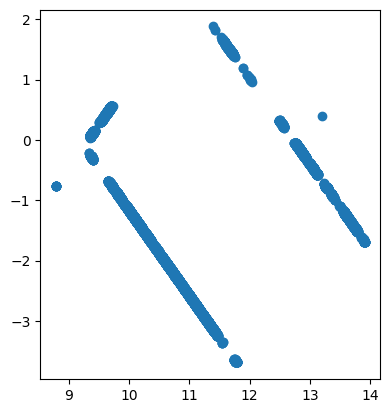

In [ ]:
try:
    import geopandas as gpd
    import matplotlib.pyplot as plt
except:
    print(
        "If you wish to visually verify your output file, "
        "you must install the `geopandas` package."
    )
else:
    gedi_gdf = gpd.read_file(output_file)
    print(gedi_gdf.head())
    agbd_colors = plt.cm.get_cmap("viridis_r")
    gedi_gdf.plot(column="agbd", cmap=agbd_colors)

<Axes: >

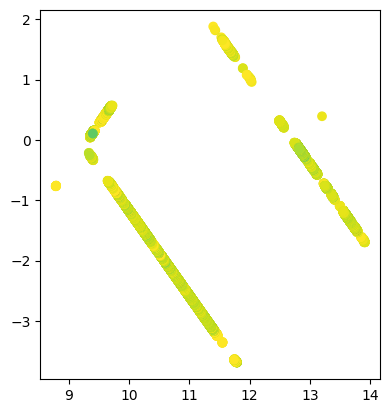

In [6]:
gedi_gdf.plot(column="agbd", cmap=agbd_colors)

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [13]:
gedi_gdf = gpd.read_file(output_file)

In [14]:
gedi_gdf

,filename,geolocation/sensitivity_a2,elev_lowestmode,sensitivity,agbd_se,agbd,geometry
0,GEDI04_A_2019111040155_O02008_02_T04616_02_002...,0.978424,27.771139,0.988014,17.123022,141.049683,POINT (9.37300 0.09770)
1,GEDI04_A_2019111040155_O02008_02_T04616_02_002...,0.979147,25.717270,0.986098,17.124018,95.756226,POINT (9.37330 0.09812)
2,GEDI04_A_2019111040155_O02008_02_T04616_02_002...,0.966114,27.040167,0.966114,17.123966,90.346252,POINT (9.37359 0.09854)
3,GEDI04_A_2019111040155_O02008_02_T04616_02_002...,0.977122,25.912329,0.983985,17.124689,113.583145,POINT (9.37389 0.09896)
4,GEDI04_A_2019111040155_O02008_02_T04616_02_002...,0.983254,25.166182,0.990431,17.123558,93.160324,POINT (9.37419 0.09939)
...,...,...,...,...,...,...,...
21966,GEDI04_A_2019114135421_O02061_04_T00905_02_002...,0.953119,60.614189,0.953119,17.132174,20.106747,POINT (9.35043 -0.25745)
21967,GEDI04_A_2019114135421_O02061_04_T00905_02_002...,0.957411,33.646351,0.970515,17.121845,161.594620,POINT (9.34984 -0.25661)
21968,GEDI04_A_2019114135421_O02061_04_T00905_02_002...,0.954684,50.559525,0.968628,17.120966,210.619934,POINT (9.34746 -0.25324)
21969,GEDI04_A_2019114135421_O02061_04_T00905_02_002...,0.979800,68.377655,0.989900,17.125740,168.208191,POINT (9.34716 -0.25281)


In [7]:
from lonboard import Map, ScatterplotLayer

In [12]:
from lonboard import viz

In [21]:
layer = ScatterplotLayer.from_geopandas(gedi_gdf)
map_ = Map(layers=[layer])

In [22]:
map_

Map(layers=[ScatterplotLayer(table=pyarrow.Table
filename: string
geolocation/sensitivity_a2: double
elev_lowe…

In [23]:
layer.get_fill_color = [255, 0, 0]

In [25]:
layer.radius_min_pixels = 2